# Ozone project for Introduction to Data Science

Load in the Helsinki data in .csv form first.

In [23]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

class Location:
    """A Location holds an ozone df, a monthly mean ozone df, and some helper methods for plotting."""
    def __init__(self, name):
        self.name = name
        self.read_data()
    
    def read_data(self):
        """Reads city data using the city name from data/<name>/*.csv."""
        files = glob.glob(f'./data/{self.name}/*.csv')
        ozone_df = pd.DataFrame()

        for file in files:
            ozone_df = pd.concat([ozone_df, pd.read_csv(file)])

        # Rename columns
        ozone_df = ozone_df.rename(columns = {'system:time_start': 'Date', 'O3_column_number_density': 'mol/m^2'})

        # Convert mol/m^2 to DU (Dobson Units), using conversion formula from
        # https://sacs.aeronomie.be/info/dobson.php
        molm2_per_du = 4.4615 * 10**(-4)
        ozone_df['DU'] = ozone_df['mol/m^2'].apply(lambda observation: observation / molm2_per_du)

        # Convert to date to datetime
        ozone_df['Date'] = pd.to_datetime(ozone_df['Date'])

        # Sort by Date and reset the index
        ozone_df = ozone_df.sort_values(by = 'Date')
        ozone_df = ozone_df.reset_index(drop = True)

        # Remove the day from date, so that we can just GroupBy date to get the monthly mean. Pandas automatically does not count NaN in mean.
        ozone_monthly_df = ozone_df.copy()
        ozone_monthly_df['Date'] = ozone_df['Date'].apply(lambda date: date.strftime('%Y-%m'))
        ozone_monthly_df['Date'] = pd.to_datetime(ozone_monthly_df['Date'])
        ozone_monthly_df = ozone_monthly_df.groupby('Date').mean().reset_index()

        # Create a timestep column to use as a linear regression variable. Counting months from 0 to n.
        ozone_monthly_df['Timestep'] = np.arange(len(ozone_monthly_df))

        self.ozone_df = ozone_df
        self.ozone_monthly_df = ozone_monthly_df
    
    def split_monthly_df(self, excluding_date):
        """Split the monthly mean df into two, exclude date from the first part. Return a tuple containing both."""
        first_part = self.ozone_monthly_df[self.ozone_monthly_df['Date'] < excluding_date]
        second_part = self.ozone_monthly_df[self.ozone_monthly_df['Date'] >= excluding_date]
        return first_part, second_part

    def plot_all_ozone_data(self, col = 'DU'):
        """Draw all ozone data in one figure."""
        ozone = self.ozone_df
        ozone_monthly = self.ozone_monthly_df

        plt.figure(figsize = (16, 8))
        plt.scatter(ozone['Date'], ozone[col], s = 1, marker = 'o')
        plt.plot(ozone_monthly['Date'], ozone_monthly[col], c='red', marker='.')
        plt.title(f'Total timeseries ozone data for {self.name}')
        plt.legend(['Daily observations', 'Monthly average'])
        plt.ylabel(col)
        plt.show()

    def plot_yearly_ozone_data(self, col = 'DU', start_year = 2019, end_year = 2024):
        """Draw yearly scatterplots of all ozone values, and the mean."""
        fig, axs = plt.subplots(2, 3)
        fig.suptitle(f'Yearly timeseries ozone data for {self.name}')
        ozone = self.ozone_df
        ozone_monthly = self.ozone_monthly_df
        row = 0

        for year_i in range(end_year - start_year + 1):
            if year_i > 0 and year_i % 3 == 0:
                row = row + 1
            
            year_df = ozone[(ozone['Date'] >= f'{year_i + start_year}-01-01') & (ozone['Date'] < f'{year_i + start_year + 1}-01-01')]
            year_avg_df = ozone_monthly[(ozone_monthly['Date'] >= f'{year_i + start_year}-01-01') & (ozone_monthly['Date'] < f'{year_i + start_year + 1}-01-01')]

            axs[row, year_i % 3].scatter(year_df['Date'], year_df[col], s = 1, marker = 'o')
            axs[row, year_i % 3].plot(year_avg_df['Date'], year_avg_df[col], c='red', marker = '.')

            axs[row, year_i % 3].set_title(f'{year_i + start_year}')
            axs[row, year_i % 3].xaxis.set_ticks([f'{year_i + start_year}-{month:02d}' + '-01' for month in range(1,13)])
            axs[row, year_i % 3].xaxis.set_ticklabels([f'{month}' for month in range(1,13)])

            # Only print the ylabel on the left side axes
            if year_i == 0 or year_i == 3:
                axs[row, year_i % 3].set_ylabel(col)

            # Only print the xlabel on the lower row
            if year_i > 2:
                axs[row, year_i % 3].set_xlabel('month')
        
        fig.set_figwidth(16)
        fig.set_figheight(8)
        fig.legend(['Daily observations', 'Monthly average'])
        plt.show()

    def boxplot_yearly_ozone_data(self, col = 'DU', start_year = 2019, end_year = 2024):
        """Draw boxplots for yearly ozone data."""
        yearly_dens = []
        tick_labels = []
        ozone = self.ozone_df

        for year_i in range(end_year - start_year + 1):
            year_df = ozone[(ozone['Date'] >= f'{year_i + start_year}-01-01') & (ozone['Date'] < f'{year_i + start_year + 1}-01-01')]
            tick_labels.append(f'{year_i + start_year}')
            # Have to drop NaNs for boxplot to work. Otherwise it shows only an empty figure.
            yearly_dens.append(year_df[col].dropna())

        plt.title(f'Yearly ozone boxplots for {self.name}')
        plt.boxplot(yearly_dens)
        plt.ylabel(col)
        plt.xticks(range(1,7), tick_labels)
        plt.show()
    
    def plot_ozone_predictions(self, dates, preds, col = 'DU'):
        """Plot predictions using all data as training data. Preds is a dict containing model_name key, and the predictions as value."""
        ozone = self.ozone_df
        ozone_monthly = self.ozone_monthly_df

        plt.figure(figsize = (16, 8))
        plt.plot(ozone_monthly['Date'], ozone_monthly[col], c='red', marker='.')
        
        for _, model_preds in preds.items():
            plt.plot(dates, model_preds, linestyle = 'dashed')

        plt.title(f'Predictions for {self.name}')
        #legends = ['Daily observations', 'Monthly average']
        legends = ['Existing monthly mean']
        legends.extend(preds.keys())
        plt.legend(legends)
        plt.ylabel(col)
        plt.show()


In [24]:
# Create Location objects for the different cities, add more here to the dictionary.
cities = {'Helsinki': Location('Helsinki'), 
          'Lahore': Location('Lahore')}

display(cities['Helsinki'].ozone_df)
display(cities['Lahore'].ozone_df)

,Date,mol/m^2,DU
0,2019-01-01,NaN,NaN
1,2019-01-01,NaN,NaN
2,2019-01-02,NaN,NaN
3,2019-01-02,0.130,291.381822
4,2019-01-02,NaN,NaN
...,...,...,...
12921,2024-09-18,NaN,NaN
12922,2024-09-19,NaN,NaN
12923,2024-09-19,0.122,273.450633
12924,2024-09-19,NaN,NaN


,Date,mol/m^2,DU
0,2019-01-01,NaN,NaN
1,2019-01-01,NaN,NaN
2,2019-01-01,NaN,NaN
3,2019-01-01,NaN,NaN
4,2019-01-01,NaN,NaN
...,...,...,...
29606,2024-09-30,NaN,NaN
29607,2024-09-30,NaN,NaN
29608,2024-09-30,NaN,NaN
29609,2024-09-30,NaN,NaN


## EDA

Looking at the date, it is immediately obvious that there are a lot of missing values (NaN). Also one day can have multiple readings, some of which were NaN. We do not need individual days, therefore let's transform the readings to monthly average. Let's visualize the data at this point as well.

In [25]:
# Display monthly mol/m^2 of Helsinki
print('Helsinki monthy data:')
display(cities['Helsinki'].ozone_monthly_df)

print('Lahore monthy data:')
display(cities['Lahore'].ozone_monthly_df)

Helsinki monthy data:


,Date,mol/m^2,DU,Timestep
0,2019-01-01,0.176746,396.157711,0
1,2019-02-01,0.171456,384.301559,1
2,2019-03-01,0.181606,407.051576,2
3,2019-04-01,0.164164,367.956818,3
4,2019-05-01,0.168526,377.733141,4
...,...,...,...,...
64,2024-05-01,0.170227,381.545818,64
65,2024-06-01,0.159578,357.677413,65
66,2024-07-01,0.151256,339.025911,66
67,2024-08-01,0.141938,318.140674,67


Lahore monthy data:


,Date,mol/m^2,DU,Timestep
0,2019-01-01,0.126062,282.556315,0
1,2019-02-01,0.129581,290.441881,1
2,2019-03-01,0.131086,293.815341,2
3,2019-04-01,0.127000,284.657626,3
4,2019-05-01,0.130556,292.627044,4
...,...,...,...,...
64,2024-05-01,0.139081,311.736145,64
65,2024-06-01,0.135722,304.207603,65
66,2024-07-01,0.131194,294.059048,66
67,2024-08-01,0.127395,285.542389,67


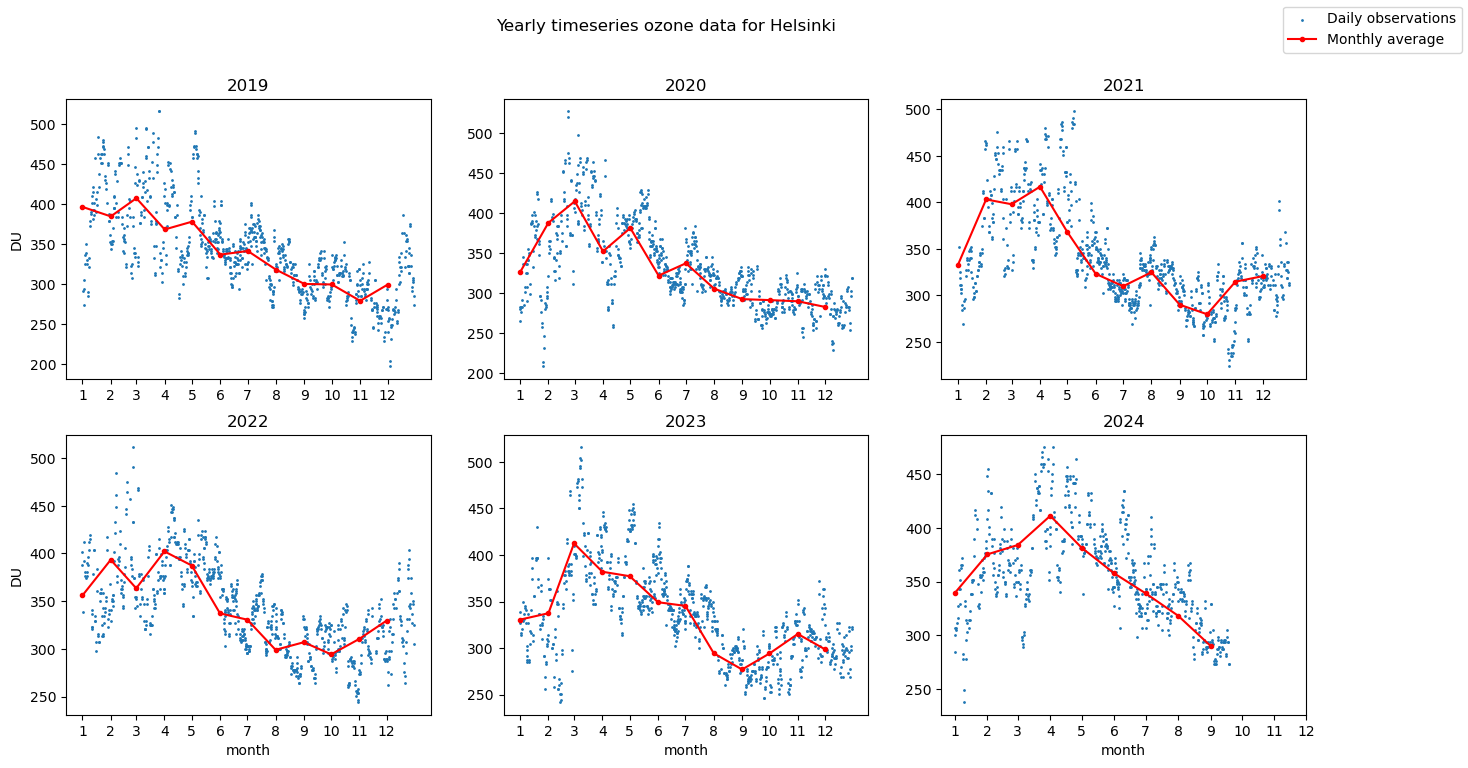

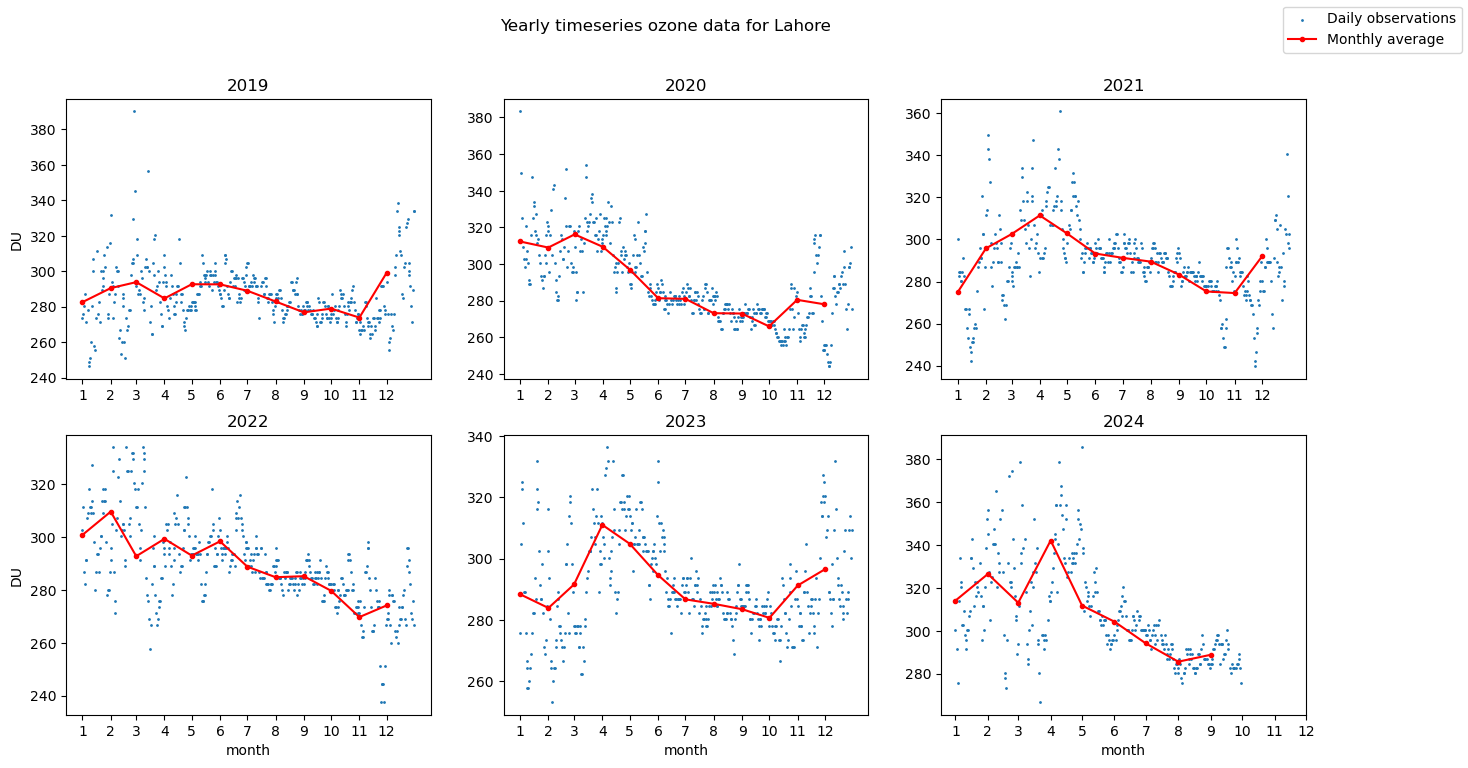

In [26]:
# Plot yearly data
cities['Helsinki'].plot_yearly_ozone_data()
cities['Lahore'].plot_yearly_ozone_data()

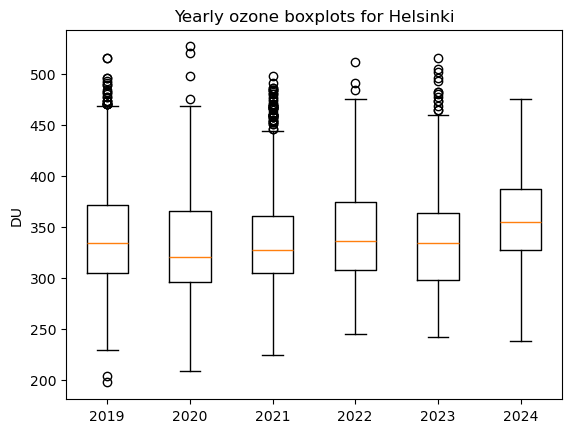

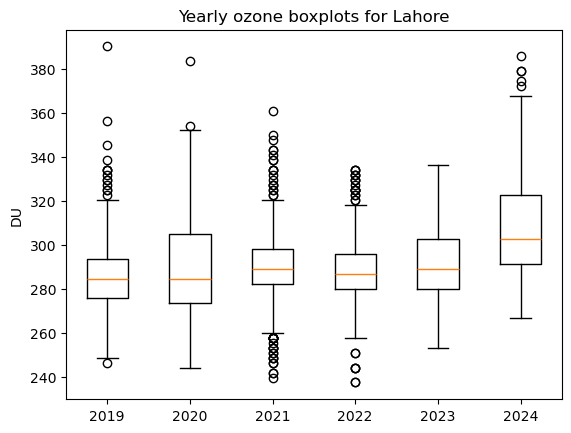

In [27]:
cities['Helsinki'].boxplot_yearly_ozone_data()
cities['Lahore'].boxplot_yearly_ozone_data()

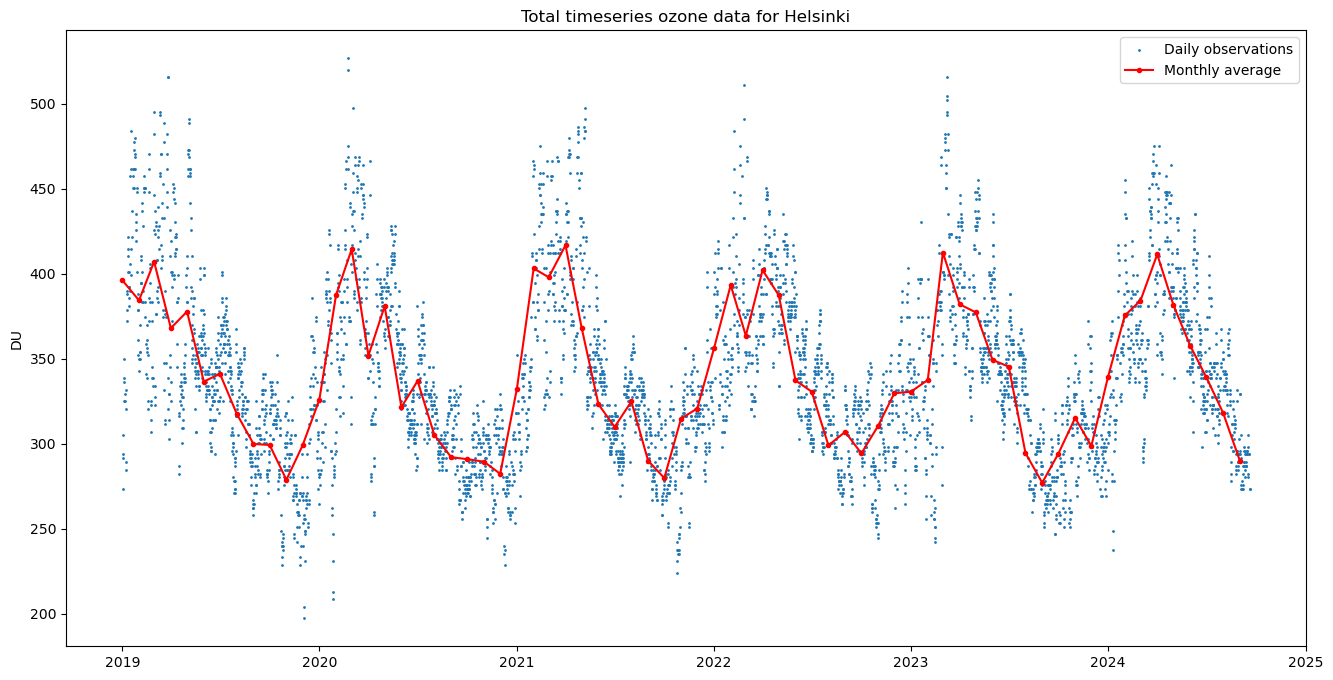

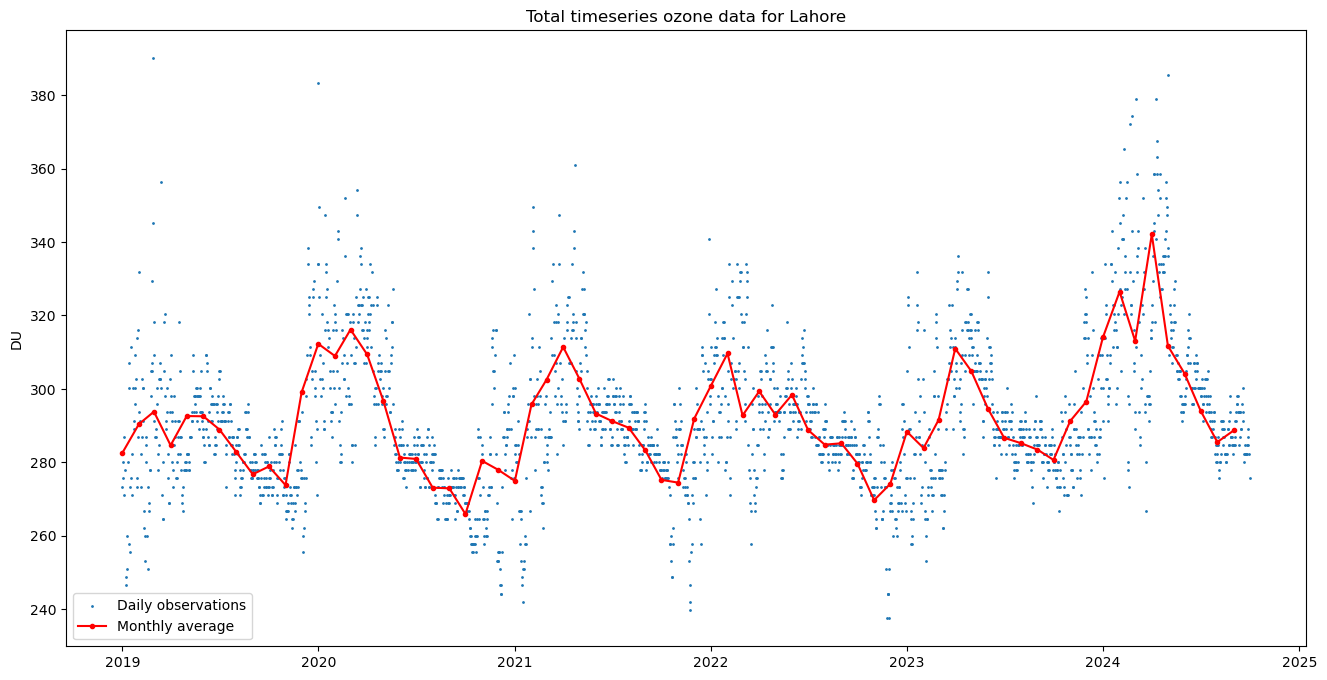

In [28]:
# Plot the whole timeseries as one
cities['Helsinki'].plot_all_ozone_data()
cities['Lahore'].plot_all_ozone_data()

# Learning

In [29]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import sklearn.base as skbase
import pmdarima

# CV test data size in months
cv_test_size = 12

class SARIMAXWrapper(skbase.BaseEstimator, skbase.RegressorMixin):
    """Used to wrap the SARIMAX model, so that it can be used like sklearn models. Idea is from
    https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible
    """
    def fit(self, X, y):
        # Use m = 12 for monthly data, X = timestep data isn't used here at all.
        self.model_fit = pmdarima.auto_arima(y, m = 12)

        return self
    
    def predict(self, X):
        n_periods = X.shape[0]
        return self.model_fit.predict(n_periods = n_periods)
    
# Models used
all_models = {'LinearRegression': LinearRegression(), 'DummyRegression': DummyRegressor(), 'SARIMAX': SARIMAXWrapper()}

def multi_eval(train_dict):
    """Evaluate multiple different time series of data."""
    # TimeSeriesSplit requires that the time intervals are fixed, which is what we have
    tscv = TimeSeriesSplit(n_splits = 2, test_size = cv_test_size)

    def eval(model, df, tscv):
        X = np.array(df['Timestep']).reshape(-1, 1)
        y = df['DU']

        cv_res = cross_validate(model, X = X, y = y, cv = tscv, 
                                scoring = ('neg_mean_squared_error', 'r2'))
        return cv_res
    
    # Create an empty dicts for holding cv results per model
    # model_results hold total mean results and individual results per location
    model_results = {}
    # Use total_locations to get the mean of all locations.
    total_locations = len(train_dict)

    # CV each model used
    for model_name, model in all_models.items():
        # indiv_results hold cv results per location
        individual_results = {}
        # mean_results hold mean mse and r2 score
        mean_results = {'mse': 0.0, 'r2': 0.0}

        # CV separately for each location in dict
        for loc_name, train in train_dict.items():
            results = eval(model, train, tscv)
            individual_results[loc_name] = results
            mean_results['mse'] = mean_results['mse'] - results['test_neg_mean_squared_error'].mean()/total_locations
            mean_results['r2'] = mean_results['r2'] + results['test_r2'].mean()/total_locations
        
        # Store model results in a tuple, with mean results first
        model_results[model_name] = (mean_results, individual_results)

    return model_results

start_date_for_test_set = '2024-01-01'
train_dict = {}
test_dict = {}

# Split all city DFs into train and test sets
for loc_name, location in cities.items():
    train, test = location.split_monthly_df(start_date_for_test_set)
    train_dict[loc_name] = train
    test_dict[loc_name] = test

# model_results is a dict that contains both the 1) model totals (mean MSE, mean R2) and 2) individual CV results as tuple values
model_results = multi_eval(train_dict)

# Print total mean results for all models
for model_name, (mean_results, _) in model_results.items():
    print(f'{model_name}: {mean_results}')

LinearRegression: {'mse': 994.5672195089346, 'r2': -0.2307602877945295}
DummyRegression: {'mse': 777.62349457855, 'r2': -0.028362435233295347}
SARIMAX: {'mse': 320.7067958787894, 'r2': 0.429712642325901}


The dummy model (the mean of previous `DU` values) seems to be better than the simple linear model, which kind of makes sense. The data has a seasonal cycle, and it might be harder to infer a linear trend from it by using just a few years as the training set. Still, the linear model might be a nice addition to seeing if the data has an overall trend to it, i.e. is the `DU` values going up or down over the whole $6$ year period of our satellite data. The SARIMAX model, that takes seasonality into account, is overwhelmingly best in both MSE and R2 scores.

Let's calculate how well the winning model (SARIMAX) generalizes to new data, the test set:

In [30]:
from sklearn.metrics import r2_score, mean_squared_error

# Use the whole training set for all locations as training data
def eval_test(model, train_dict, test_dict):
    """Evaluates the MSE and R2 of the model, using all the training data against the test data."""
    results = {'mse': 0.0, 'r2': 0.0}
    total_locations = len(train_dict)

    for loc_name, train in train_dict.items():
        test = test_dict[loc_name]
        X = np.array(train['Timestep']).reshape(-1, 1)
        X_test = np.array(test['Timestep']).reshape(-1, 1)
        
        fit = model.fit(X = X, y = train['DU'])
        test_preds = fit.predict(X_test)
        mse = mean_squared_error(test['DU'], test_preds)
        r2 = r2_score(test['DU'], test_preds)

        results['mse'] = results['mse'] + mse/total_locations
        results['r2'] = results['r2'] + r2/total_locations
    
    return results

# Get the size of the test set in months
n_periods = len(test_dict['Helsinki'])
test_results = eval_test(SARIMAXWrapper(), train_dict, test_dict)
print(f'SARIMAX test results: {test_results}')

SARIMAX test results: {'mse': 486.62995103501527, 'r2': -0.1291792987050261}


# Predictions

The results of the DummyRegresser and the LinearRegressor were bad, as expected, since the models do not capture any of the cyclic nature of the data. Let's use linear regression and the SARIMAX models as the final predictors. The linear regression will show a possible overall linear trend in the data.

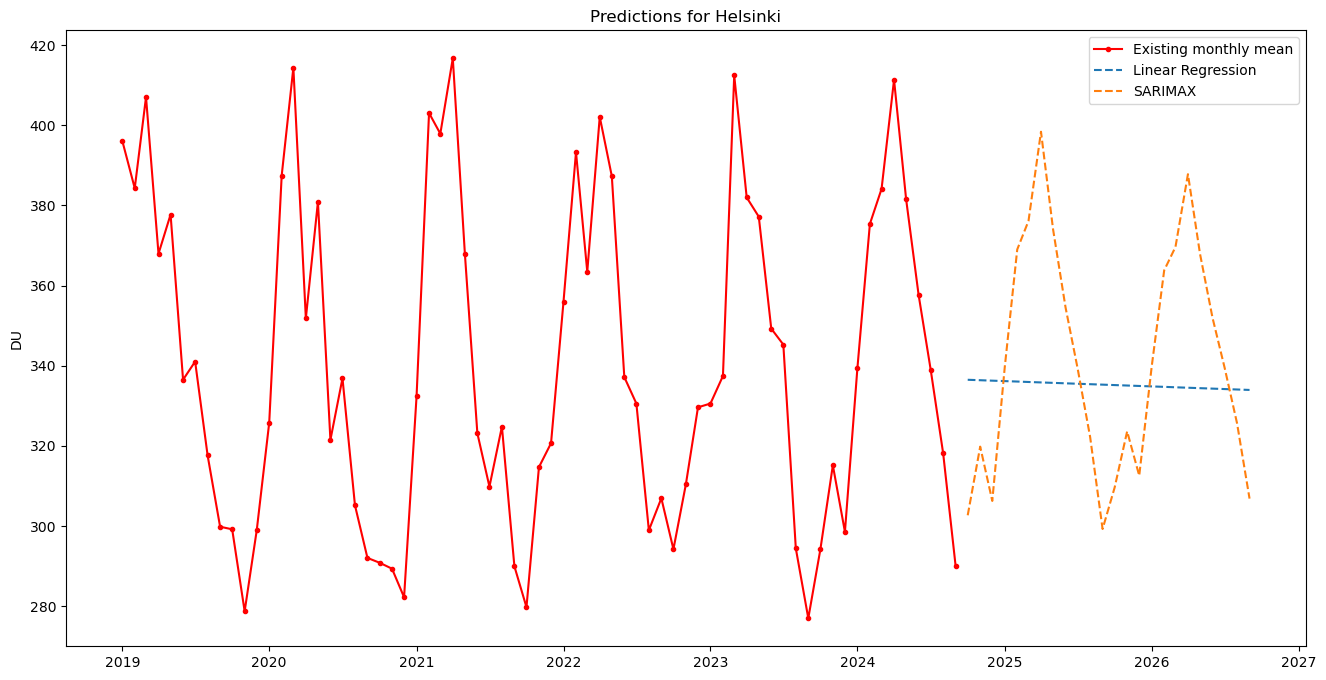

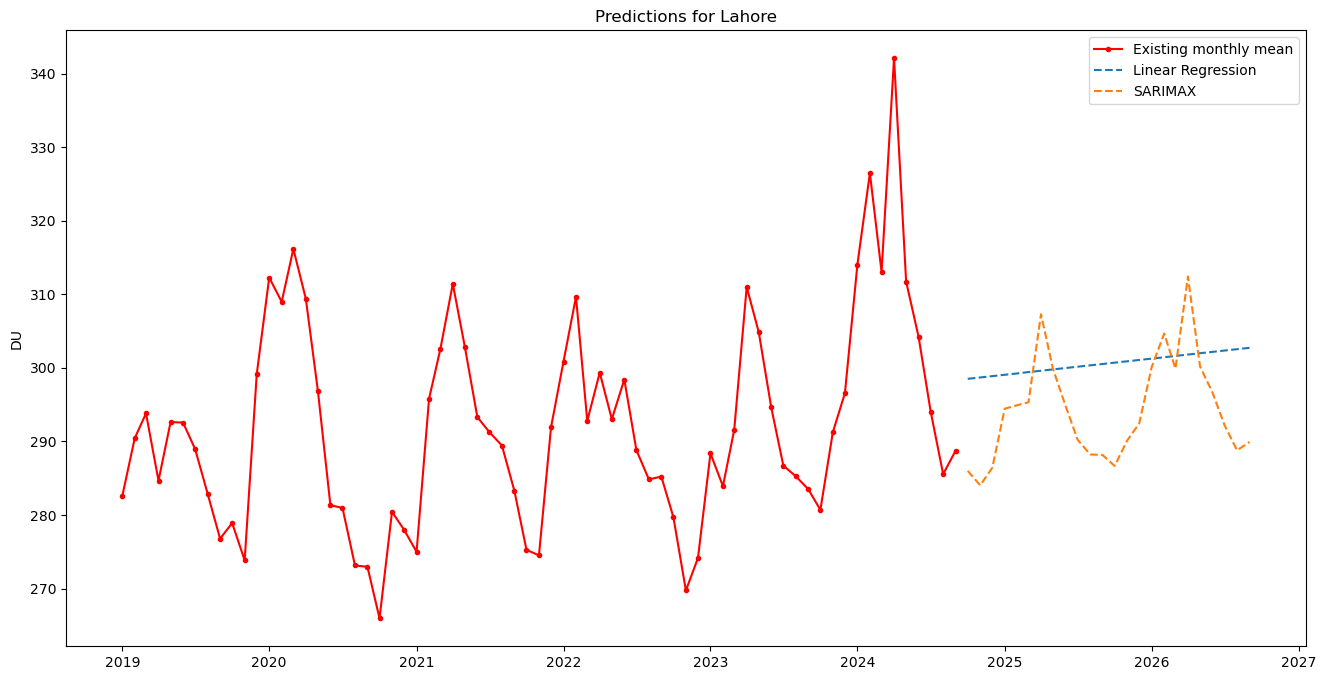

In [31]:
def create_datetime_series(monthly_df, months):
    # Create a datetime series for the predictions, used in plotting.
    dates = []
    last_date = monthly_df['Date'].iloc[-1]

    for i in range(1, months + 1):
        dates.append(last_date + pd.DateOffset(months=i))
    
    return pd.Series(dates)

def create_features(monthly_df, months):
    # Create X, X_future matrix used in fitting and predictions.
    X = np.array(monthly_df['Timestep']).reshape(-1, 1)
    last_timestep = monthly_df['Timestep'].iloc[-1]
    X_future = np.arange(last_timestep + 1, last_timestep + 1 + months).reshape(-1, 1)

    return X, X_future

# Predict 2 year ahead
pred_months = 24

# Dict with key = location_name, value = (model name, predictions) tuple.
all_preds = {}

for loc_name, test in test_dict.items():
    # Take the last month of each test dict, and create future dates.
    monthly_df = cities[loc_name].ozone_monthly_df
    dates = create_datetime_series(monthly_df, pred_months)
    X, X_future = create_features(monthly_df, pred_months)

    plot_models = {'Linear Regression': LinearRegression(), 'SARIMAX': SARIMAXWrapper()}
    model_preds = {}

    for model_name, model_class in plot_models.items():
        fit = model_class.fit(X=X, y=monthly_df['DU'])
        preds = fit.predict(X_future)
        model_preds[model_name] = preds
    
    all_preds[loc_name] = (dates, model_preds)

for loc_name, (dates, model_preds) in all_preds.items():
    cities[loc_name].plot_ozone_predictions(dates, model_preds)